## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

### 1.2. Data Loading and Preprocessing (3 points)

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
from torch.utils.data import random_split
# Path to the dataset directory
dataset_directory = 'pa3_subset_animal'  # Change this to your dataset path

# Preprocessing transformations: resize, normalize, and random horizontal flip for data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Resize images to 256x256
    transforms.RandomHorizontalFlip(),          # Random horizontal flip for augmentation
    transforms.ToTensor(),                      # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_directory, transform=transform)

# Split the dataset into 3 parts: 3000 for training, 750 for validation, 750 for testing
num_classes = len(full_dataset.classes)  # Number of classes in the dataset
images_per_class = 300  # 300 images per class for training
total_images = num_classes * images_per_class

# Define lengths of the splits
train_size = num_classes * 300  # 300 images per class for training
val_size = num_classes * 75     # 75 images per class for validation
test_size = num_classes * 75    # 75 images per class for testing

# Split the dataset (shuffling ensures random splitting)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoader for training, validation, and testing
batch_size = 32  # Set an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for images, labels in train_loader:
    print(f"Training batch shape: {images.shape}")  # Should print (batch_size, channels, 256, 256)
    print(f"Labels batch shape: {labels.shape}")    # Should print (batch_size,)
    break  # Stop after one batch

Training batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

My architecture extract features in first step that provides avoids images noises after normalize input this features must train according to outputs. Actually I did this architecture from pdf.

RElu function is good for huge models because training costs decreases with cheaper derivative.
One more reason is in negative values of RElu transforms to zero. That means in some inputs this neuron acts like dropout that can be active auto.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # CNN design as written in pdf

        # First Convolutional Layer (Conv1)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel size of 2

        # (Conv2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # (Conv3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # (Conv4)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)  # Flattened size after pooling
        self.fc2 = nn.Linear(1024, num_classes)  # Output layer with 10 classes for Animal-10

    def forward(self, x):
        # Apply convolutional layers with ReLU activations
        
        # Forward function utilizing pdfs order
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 256 * 16 * 16)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final output layer

        return x


### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.
* CrossEntropyLoss use softmax function while multiclass classifications so this is integrating predictions to probabilistic distribution
* Adam optimizer using in big models for decrease training time.

In [5]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()

In [191]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
#4 Model for different hyperparameters

model1 = CustomCNN()
model2 = CustomCNN()
model3 = CustomCNN()
model4 = CustomCNN()


models_ = [model1, model2, model3, model4]

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001) # Train with different lrs
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)



### 1.5 Train and Validate the CNN model (9 points)

In [14]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)
import matplotlib.pyplot as plt

# Manipulate data with different batch size
train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) # Train with different batch_sizes
val_loader1 = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_dataset, batch_size= 128, shuffle=False)

In [193]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    print(f"Batch Size : {train_loader.batch_size}") # Provides to see which hyperparameters are good at 4-5 epochs. So I decide which of them should train in 30 epochs  
    best_val_accuracy = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []} # Models History

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
            
        for inputs, labels in train_loader:
            optimizer.zero_grad() # Initialize gradients 0 for avoid any error
            outputs = model(inputs) # Calculate outputs for train model
            loss = criterion(outputs, labels) # Loss calculation according to CrossEntropyLoss
            loss.backward() # Gradient descent
            optimizer.step()
            running_loss += loss.item() 

        # Validation for every epoch same code will use in evaluate function
        model.eval() 
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        history['train_loss'].append(running_loss / len(train_loader)) # Add information about models history
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss = {running_loss / len(train_loader):.4f}, Val Loss = {val_loss / len(val_loader):.4f}, Val Accuracy = {val_accuracy:.4f}")

    return history

In [194]:
# Instantiate and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device}")


history1 = train_model(model1, criterion, optimizer1, train_loader1, val_loader, epochs= 30) # Batch size 64 lr = 0.001

history2 = train_model(model2, criterion, optimizer2, train_loader2 , val_loader, epochs= 30) # Batch size 128 lr = 0.001

history3 = train_model(model3, criterion, optimizer3, train_loader1, val_loader, epochs= 30) # Batch size 64 lr = 0.001

history4 = train_model(model4, criterion, optimizer4, train_loader2 , val_loader, epochs= 30) # Batch size 128 lr = 0.001


cpu
Batch Size : 64
Epoch 1/30: Train Loss = 2.4716, Val Loss = 2.3010, Val Accuracy = 0.0960
Epoch 2/30: Train Loss = 2.2474, Val Loss = 2.1706, Val Accuracy = 0.2107
Epoch 3/30: Train Loss = 2.1282, Val Loss = 2.0520, Val Accuracy = 0.2680
Epoch 4/30: Train Loss = 1.9312, Val Loss = 1.8395, Val Accuracy = 0.3280
Epoch 5/30: Train Loss = 1.7156, Val Loss = 1.7087, Val Accuracy = 0.3800
Epoch 6/30: Train Loss = 1.5208, Val Loss = 1.6363, Val Accuracy = 0.4267
Epoch 7/30: Train Loss = 1.3549, Val Loss = 1.6540, Val Accuracy = 0.4627
Epoch 8/30: Train Loss = 1.1558, Val Loss = 1.6573, Val Accuracy = 0.4240
Epoch 9/30: Train Loss = 0.9620, Val Loss = 1.6561, Val Accuracy = 0.4320
Epoch 10/30: Train Loss = 0.8045, Val Loss = 1.8269, Val Accuracy = 0.4480
Epoch 11/30: Train Loss = 0.6268, Val Loss = 2.0776, Val Accuracy = 0.4707
Epoch 12/30: Train Loss = 0.4444, Val Loss = 2.6670, Val Accuracy = 0.4533
Epoch 13/30: Train Loss = 0.3622, Val Loss = 2.6610, Val Accuracy = 0.4467
Epoch 14/30: T

Mention about, why did you choose your learning rate and batch size?

My lr and batch size choose from best performing model according to validation data.

In [6]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

histories = [history1, history2 ,history3 , history4] # List of model histories
best_model_index = histories.index(max(histories, key=lambda x: max(x['val_accuracy']))) # Take best models index


# Assign the best model to 'model'

model = models_[best_model_index]
torch.save(model, "best_model_for_first.pth") # Save best model in first part

if(best_model_index > 1): # Choose best lr according to best model
    lr = 0.01
else:
    lr = 0.001
    
if(best_model_index  %   2 == 1): # Choose best batch_size according to best model
    batch_size = 128
else:
    batch_size = 64

print(f"The best model is model{best_model_index if best_model_index != 0 else ''}")


NameError: name 'history1' is not defined

### 1.6 Evaluate the trained model on the test set (6 points)

Test Set Metrics:
Accuracy: 0.8173
Precision: 0.8193
Recall: 0.8173
F1-Score: 0.8174


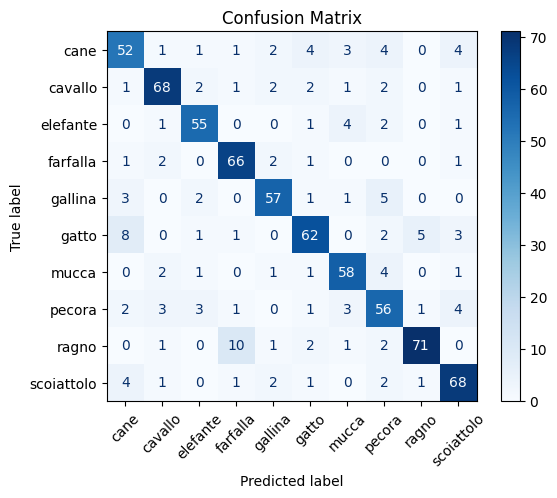

In [15]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, test_loader, full_dataset): 
    model.eval()
    all_labels = []
    all_preds = []
    
    # Get class names from the original full_dataset
    class_names = full_dataset.classes 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Evaluate model on test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the appropriate device (GPU if available, else CPU)
            inputs = inputs.to(device)  
            labels = labels.to(device)  

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print and visualize results
    print("Test Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Display confusion matrix with extracted class names
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

results = evaluate_model(model, test_loader , full_dataset)

### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

Test accuracy shows as 0.81. But I think it stems from an error. When I trained this data accuracy was approximately 0.52
Actually I didn't struggle this part because training times were much more than before assignments. So trying new things was very expensive for me.
Indeed this CNN architecture is not good for catching nonlinear patterns because it has one layer after extract features. When patterns getting harder this CNN arc. can not 
sufficient for its patterns. This model can grown with other layers.But it will be more expensive...


### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.
--------0.456--------- (Rtn_Adn)


## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?
For increase models generalization skills.  

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [202]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.
import torchvision.models as models
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights, MobileNet_V2_Weights

# Use pretrained weights for ResNet18
weights = ResNet18_Weights.DEFAULT  # Use the default pretrained weights
model = resnet18(weights=weights)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


summary(model, input_size=(3, 224, 224))  # Assumes input images are RGB of size 224x224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [203]:
from torch import optim

## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)

# 1. Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# 2. Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# 3. Replace the final fully connected layer
num_ftrs = resnet18.fc.in_features  # Get the number of features in the last layer
resnet18.fc = nn.Linear(num_ftrs, 10)  # Replace with a new layer for 10 classes (Animal-10)

# 4. Unfreeze the final FC layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

# 5. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(resnet18.fc.parameters(), lr= lr, momentum=0.9) 

# 6. Train the model (assuming you have train_loader and val_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

num_epochs = 30  # Adjust as needed
for epoch in range(num_epochs):
    # Training loop
    resnet18.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/30], Loss: 0.7307
Epoch [2/30], Loss: 0.3360
Epoch [3/30], Loss: 0.2906
Epoch [4/30], Loss: 0.2027
Epoch [5/30], Loss: 0.2214
Epoch [6/30], Loss: 0.1183
Epoch [7/30], Loss: 0.2711
Epoch [8/30], Loss: 0.1193
Epoch [9/30], Loss: 0.0950
Epoch [10/30], Loss: 0.1863
Epoch [11/30], Loss: 0.1768
Epoch [12/30], Loss: 0.1900
Epoch [13/30], Loss: 0.1198
Epoch [14/30], Loss: 0.1397
Epoch [15/30], Loss: 0.0812
Epoch [16/30], Loss: 0.2967
Epoch [17/30], Loss: 0.1112
Epoch [18/30], Loss: 0.1782
Epoch [19/30], Loss: 0.1657
Epoch [20/30], Loss: 0.2634
Epoch [21/30], Loss: 0.0748
Epoch [22/30], Loss: 0.3874
Epoch [23/30], Loss: 0.1116
Epoch [24/30], Loss: 0.2504
Epoch [25/30], Loss: 0.0880
Epoch [26/30], Loss: 0.2385
Epoch [27/30], Loss: 0.1834
Epoch [28/30], Loss: 0.1799
Epoch [29/30], Loss: 0.1181
Epoch [30/30], Loss: 0.1363


In [204]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

# 1. Load pre-trained ResNet18
resnet18_model2 = models.resnet18(pretrained=True)

# 2. Freeze all layers
for param in resnet18_model2.parameters():
    param.requires_grad = False

# 3. Replace the final fully connected layer
num_ftrs = resnet18_model2.fc.in_features
resnet18_model2.fc = nn.Linear(num_ftrs, 10) 

# 4. Unfreeze the final FC layer
for param in resnet18_model2.fc.parameters():
    param.requires_grad = True

# 5. Unfreeze convolutional layers 3 and 4
# ResNet18 layers are accessed using 'layer1', 'layer2', 'layer3', 'layer4'
for param in resnet18_model2.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model2.layer4.parameters():
    param.requires_grad = True

# 6. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet18_model2.parameters()), lr=lr, momentum=0.9)

# 7. Train the model (assuming you have train_loader and val_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model2.to(device)

num_epochs = 30  # Adjust as needed
for epoch in range(num_epochs):
    # Training loop
    resnet18_model2.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/30], Loss: 0.4539
Epoch [2/30], Loss: 0.1843
Epoch [3/30], Loss: 0.2551
Epoch [4/30], Loss: 0.0754
Epoch [5/30], Loss: 0.0841
Epoch [6/30], Loss: 0.0531
Epoch [7/30], Loss: 0.0213
Epoch [8/30], Loss: 0.1292
Epoch [9/30], Loss: 0.0363
Epoch [10/30], Loss: 0.0410
Epoch [11/30], Loss: 0.0066
Epoch [12/30], Loss: 0.0108
Epoch [13/30], Loss: 0.0342
Epoch [14/30], Loss: 0.0065
Epoch [15/30], Loss: 0.0211
Epoch [16/30], Loss: 0.0924
Epoch [17/30], Loss: 0.0095
Epoch [18/30], Loss: 0.0155
Epoch [19/30], Loss: 0.0112
Epoch [20/30], Loss: 0.0052
Epoch [21/30], Loss: 0.0091
Epoch [22/30], Loss: 0.0085
Epoch [23/30], Loss: 0.0064
Epoch [24/30], Loss: 0.0061
Epoch [25/30], Loss: 0.0032
Epoch [26/30], Loss: 0.0075
Epoch [27/30], Loss: 0.0080
Epoch [28/30], Loss: 0.0047
Epoch [29/30], Loss: 0.0054
Epoch [30/30], Loss: 0.0334


In [205]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

# 1. Load pre-trained ResNet18
resnet18_model3 = models.resnet18(pretrained=True)

# 2. Replace the final fully connected layer
num_ftrs = resnet18_model3.fc.in_features
resnet18_model3.fc = nn.Linear(num_ftrs, 10)  

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(resnet18_model3.parameters(), lr=lr, momentum=0.9) 

# 4. Train the model (assuming you have train_loader and val_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model3.to(device)

num_epochs = 30  # Adjust as needed
for epoch in range(num_epochs):
    # Training loop
    resnet18_model3.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/30], Loss: 0.2953
Epoch [2/30], Loss: 0.2958
Epoch [3/30], Loss: 0.1270
Epoch [4/30], Loss: 0.1557
Epoch [5/30], Loss: 0.1429
Epoch [6/30], Loss: 0.0874
Epoch [7/30], Loss: 0.0605
Epoch [8/30], Loss: 0.0335
Epoch [9/30], Loss: 0.0125
Epoch [10/30], Loss: 0.0284
Epoch [11/30], Loss: 0.0599
Epoch [12/30], Loss: 0.0121
Epoch [13/30], Loss: 0.0210
Epoch [14/30], Loss: 0.0052
Epoch [15/30], Loss: 0.0069
Epoch [16/30], Loss: 0.0227
Epoch [17/30], Loss: 0.0021
Epoch [18/30], Loss: 0.0126
Epoch [19/30], Loss: 0.0194
Epoch [20/30], Loss: 0.0218
Epoch [21/30], Loss: 0.0119
Epoch [22/30], Loss: 0.0267
Epoch [23/30], Loss: 0.0052
Epoch [24/30], Loss: 0.0034
Epoch [25/30], Loss: 0.0152
Epoch [26/30], Loss: 0.0027
Epoch [27/30], Loss: 0.0222
Epoch [28/30], Loss: 0.0045
Epoch [29/30], Loss: 0.0275
Epoch [30/30], Loss: 0.0014


Model 1, Epoch [1/30], Train Loss: 0.1232, Val Loss: 0.1658, Val Acc: 0.9493
Model 2, Epoch [1/30], Train Loss: 0.0059, Val Loss: 0.1403, Val Acc: 0.9560
Model 3, Epoch [1/30], Train Loss: 0.0041, Val Loss: 0.1281, Val Acc: 0.9573
Model 1, Epoch [2/30], Train Loss: 0.1230, Val Loss: 0.1580, Val Acc: 0.9533
Model 2, Epoch [2/30], Train Loss: 0.0064, Val Loss: 0.1526, Val Acc: 0.9547
Model 3, Epoch [2/30], Train Loss: 0.0047, Val Loss: 0.1334, Val Acc: 0.9573
Model 1, Epoch [3/30], Train Loss: 0.1260, Val Loss: 0.1583, Val Acc: 0.9493
Model 2, Epoch [3/30], Train Loss: 0.0049, Val Loss: 0.1396, Val Acc: 0.9613
Model 3, Epoch [3/30], Train Loss: 0.0048, Val Loss: 0.1278, Val Acc: 0.9587
Model 1, Epoch [4/30], Train Loss: 0.1148, Val Loss: 0.1576, Val Acc: 0.9507
Model 2, Epoch [4/30], Train Loss: 0.0059, Val Loss: 0.1461, Val Acc: 0.9560
Model 3, Epoch [4/30], Train Loss: 0.0040, Val Loss: 0.1343, Val Acc: 0.9560
Model 1, Epoch [5/30], Train Loss: 0.1109, Val Loss: 0.1491, Val Acc: 0.9560

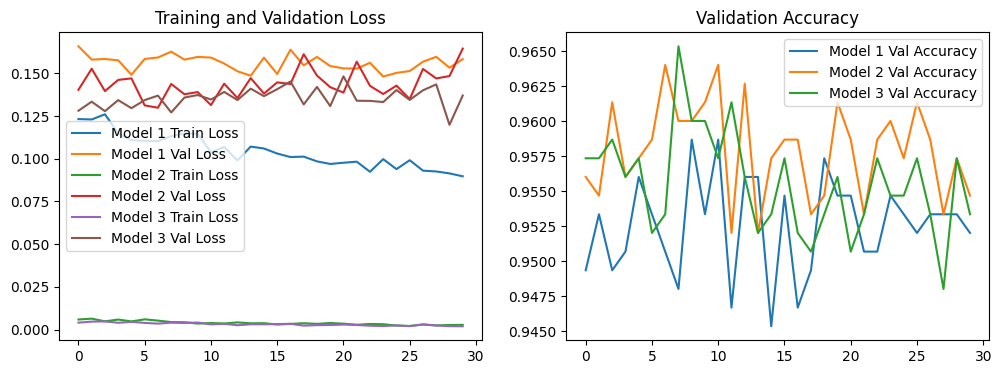

In [206]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.


# --- Model Definitions (from previous responses) ---
# (resnet18, resnet18_model2, resnet18_model3 definitions here)
# ---

# Loss function and optimizer (same for all models)
criterion = nn.CrossEntropyLoss()

# Optimizers (different for each model based on unfrozen layers)
optimizer1 = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(filter(lambda p: p.requires_grad, resnet18_model2.parameters()), lr=lr, momentum=0.9)
optimizer3 = optim.SGD(resnet18_model3.parameters(), lr=0.001, momentum=0.9)

# Training and Validation Loop
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [resnet18, resnet18_model2, resnet18_model3]
optimizers = [optimizer1, optimizer2, optimizer3]
history = [{'train_loss': [], 'val_loss': [], 'val_acc': []} for _ in range(3)]

for epoch in range(num_epochs):
    for i, model in enumerate(models):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader: # Simple training method as first part
            inputs, labels = inputs.to(device), labels.to(device)
            optimizers[i].zero_grad() # Avoid any error in grad des
            outputs = model(inputs) # Take outputs for grad des
            loss = criterion(outputs, labels) # Crs Entropy for multiclass
            loss.backward() # Backprop
            optimizers[i].step()
            running_loss += loss.item()
        history[i]['train_loss'].append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad(): 
            for inputs, labels in val_loader: # Evaluate functions short part for see performance in different epochs
                inputs, labels = inputs.to(device), labels.to(device) 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        history[i]['val_loss'].append(val_loss / len(val_loader))
        history[i]['val_acc'].append(correct / total)

        print(f"Model {i+1}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {history[i]['train_loss'][-1]:.4f}, Val Loss: {history[i]['val_loss'][-1]:.4f}, Val Acc: {history[i]['val_acc'][-1]:.4f}")

# Visualization
plt.figure(figsize=(12, 4)) #Compare Models with 2 different charts
plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(history[i]['train_loss'], label=f"Model {i+1} Train Loss")
    plt.plot(history[i]['val_loss'], label=f"Model {i+1} Val Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(history[i]['val_acc'], label=f"Model {i+1} Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show() 

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.
Validation acc is more important than training so in second chart Model2 is better than others after 30 epochs
If validation accuracy more than others that means this model has best generalize skills. Because validation set is independent. 
 

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

Test Set Metrics:
Accuracy: 0.9587
Precision: 0.9598
Recall: 0.9587
F1-Score: 0.9589


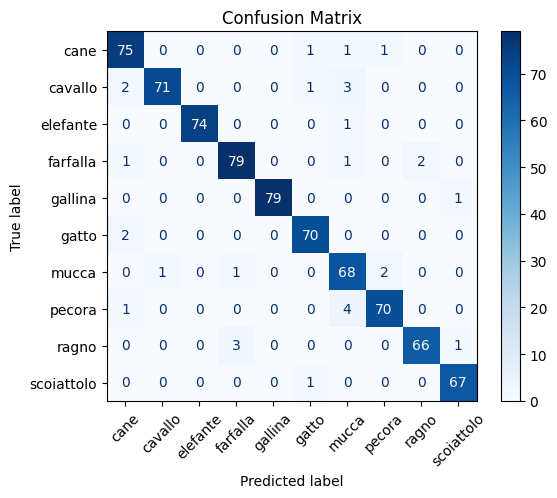

In [207]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch
best_model_index = history.index(max(history, key=lambda x: max(x['val_acc'])))
best_model = models[best_model_index]

torch.save(best_model, "best_model_for_second.pth")

resnet18_results = evaluate_model(best_model, test_loader, full_dataset)

### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

--------0.962--------- (Rtn_Adn)


### 2.7. Load the pre-trained MobileNet model (3 points)


In [208]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.

import torchvision.models as models
from torchsummary import summary 
from torchvision.models import MobileNet_V2_Weights

# Load the pre-trained MobileNetV2 model with the default weights
mobilenet_v2 = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT) # Import mobilenet from torch

# Check the model's architecture
summary(mobilenet_v2, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [209]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# 1. Load pre-trained MobileNetV2
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# 2. Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# 3. Replace the final fully connected layer
num_ftrs = mobilenet_v2.classifier[1].in_features  # Get number of features in the last layer
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, 10)  # Replace with a new layer for 10 classes

# 4. Unfreeze the final FC layer
for param in mobilenet_v2.classifier[1].parameters():
    param.requires_grad = True

# 5. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_v2.classifier[1].parameters(), lr=lr, momentum=0.9)

# 6. Train the model (assuming you have train_loader and val_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2.to(device)

num_epochs = 30  # Adjust as needed
for epoch in range(num_epochs):
    # Training loop
    mobilenet_v2.train()
    for inputs, labels in train_loader: # Same training codes
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

C:\Users\Bedirhan\Desktop\PycharmProjects\deneme\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Bedirhan\Desktop\PycharmProjects\deneme\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.6699
Epoch [2/30], Loss: 0.7086
Epoch [3/30], Loss: 0.2694
Epoch [4/30], Loss: 0.3020
Epoch [5/30], Loss: 0.3594
Epoch [6/30], Loss: 0.2151
Epoch [7/30], Loss: 0.1632
Epoch [8/30], Loss: 0.2451
Epoch [9/30], Loss: 0.2609
Epoch [10/30], Loss: 0.3426
Epoch [11/30], Loss: 0.0978
Epoch [12/30], Loss: 0.1282
Epoch [13/30], Loss: 0.4386
Epoch [14/30], Loss: 0.2637
Epoch [15/30], Loss: 0.2215
Epoch [16/30], Loss: 0.3203
Epoch [17/30], Loss: 0.0632
Epoch [18/30], Loss: 0.0937
Epoch [19/30], Loss: 0.0713
Epoch [20/30], Loss: 0.1620
Epoch [21/30], Loss: 0.1627
Epoch [22/30], Loss: 0.0533
Epoch [23/30], Loss: 0.0925
Epoch [24/30], Loss: 0.3311
Epoch [25/30], Loss: 0.3179
Epoch [26/30], Loss: 0.0968
Epoch [27/30], Loss: 0.2118
Epoch [28/30], Loss: 0.0744
Epoch [29/30], Loss: 0.1792
Epoch [30/30], Loss: 0.1534


In [210]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# 1. Load pre-trained MobileNetV2
mobilenet_v2_model2 = models.mobilenet_v2(pretrained=True)

# 2. Replace the final fully connected layer
num_ftrs = mobilenet_v2_model2.classifier[1].in_features
mobilenet_v2_model2.classifier[1] = nn.Linear(num_ftrs, 10) 

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_v2_model2.parameters(), lr=lr, momentum=0.9)

# 4. Train the model (assuming you have train_loader and val_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model2.to(device)

num_epochs = 30  # Adjust as needed
for epoch in range(num_epochs):
    # Training loop
    mobilenet_v2_model2.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/30], Loss: 0.4310
Epoch [2/30], Loss: 0.1377
Epoch [3/30], Loss: 0.0634
Epoch [4/30], Loss: 0.1967
Epoch [5/30], Loss: 0.0352
Epoch [6/30], Loss: 0.0724
Epoch [7/30], Loss: 0.0673
Epoch [8/30], Loss: 0.0149
Epoch [9/30], Loss: 0.0253
Epoch [10/30], Loss: 0.0187
Epoch [11/30], Loss: 0.0086
Epoch [12/30], Loss: 0.0204
Epoch [13/30], Loss: 0.0181
Epoch [14/30], Loss: 0.0086
Epoch [15/30], Loss: 0.0123
Epoch [16/30], Loss: 0.0024
Epoch [17/30], Loss: 0.0115
Epoch [18/30], Loss: 0.0100
Epoch [19/30], Loss: 0.0124
Epoch [20/30], Loss: 0.0015
Epoch [21/30], Loss: 0.0079
Epoch [22/30], Loss: 0.0018
Epoch [23/30], Loss: 0.0050
Epoch [24/30], Loss: 0.0026
Epoch [25/30], Loss: 0.0113
Epoch [26/30], Loss: 0.0028
Epoch [27/30], Loss: 0.0221
Epoch [28/30], Loss: 0.0048
Epoch [29/30], Loss: 0.0035
Epoch [30/30], Loss: 0.0012


Model 1, Epoch [1/30], Train Loss: 0.1270, Val Loss: 0.1754, Val Acc: 0.9467
Model 2, Epoch [1/30], Train Loss: 0.0044, Val Loss: 0.1674, Val Acc: 0.9547
Model 1, Epoch [2/30], Train Loss: 0.1276, Val Loss: 0.1651, Val Acc: 0.9613
Model 2, Epoch [2/30], Train Loss: 0.0048, Val Loss: 0.1594, Val Acc: 0.9480
Model 1, Epoch [3/30], Train Loss: 0.1278, Val Loss: 0.1670, Val Acc: 0.9493
Model 2, Epoch [3/30], Train Loss: 0.0036, Val Loss: 0.1710, Val Acc: 0.9547
Model 1, Epoch [4/30], Train Loss: 0.1364, Val Loss: 0.1668, Val Acc: 0.9533
Model 2, Epoch [4/30], Train Loss: 0.0033, Val Loss: 0.1701, Val Acc: 0.9493
Model 1, Epoch [5/30], Train Loss: 0.1287, Val Loss: 0.1691, Val Acc: 0.9520
Model 2, Epoch [5/30], Train Loss: 0.0030, Val Loss: 0.1616, Val Acc: 0.9480
Model 1, Epoch [6/30], Train Loss: 0.1268, Val Loss: 0.1680, Val Acc: 0.9507
Model 2, Epoch [6/30], Train Loss: 0.0030, Val Loss: 0.1602, Val Acc: 0.9587
Model 1, Epoch [7/30], Train Loss: 0.1246, Val Loss: 0.1607, Val Acc: 0.9560

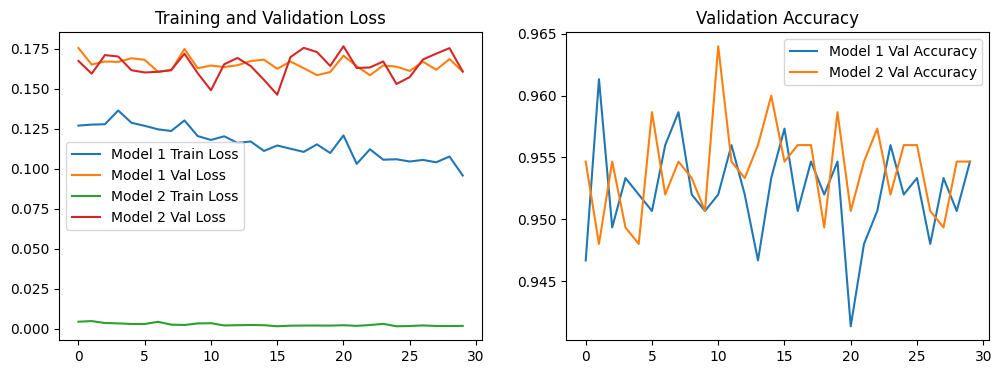

In [211]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Model Definitions (from previous responses) ---
# (mobilenet_v2, mobilenet_v2_model2 definitions here)
# ---

# Loss function and optimizer (same for all models)
criterion = nn.CrossEntropyLoss()

# Optimizers (different for each model based on unfrozen layers)
optimizer1 = optim.SGD(mobilenet_v2.classifier[1].parameters(), lr=lr, momentum=0.9)
optimizer2 = optim.SGD(mobilenet_v2_model2.parameters(), lr=lr, momentum=0.9)

# Training and Validation Loop
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [mobilenet_v2, mobilenet_v2_model2]
optimizers = [optimizer1, optimizer2]
history = [{'train_loss': [], 'val_loss': [], 'val_acc': []} for _ in range(2)]

for epoch in range(num_epochs):
    for i, model in enumerate(models): # Same training codes
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizers[i].zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[i].step()
            running_loss += loss.item()
        history[i]['train_loss'].append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader: # Same validation code part
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        history[i]['val_loss'].append(val_loss / len(val_loader))
        history[i]['val_acc'].append(correct / total)

        print(f"Model {i+1}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {history[i]['train_loss'][-1]:.4f}, Val Loss: {history[i]['val_loss'][-1]:.4f}, Val Acc: {history[i]['val_acc'][-1]:.4f}")

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(2):
    plt.plot(history[i]['train_loss'], label=f"Model {i+1} Train Loss")
    plt.plot(history[i]['val_loss'], label=f"Model {i+1} Val Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
for i in range(2):
    plt.plot(history[i]['val_acc'], label=f"Model {i+1} Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

It seems like equal. But consider chart 2 Model2 generally stays on Model1. I think it depends on starting parameters. Model2 started with better parameters for this patterns. 
So I can say to when we increasing epoch number Model2 can generalize better.

This question has same answer with first one.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Test Set Metrics:
Accuracy: 0.9547
Precision: 0.9554
Recall: 0.9547
F1-Score: 0.9547


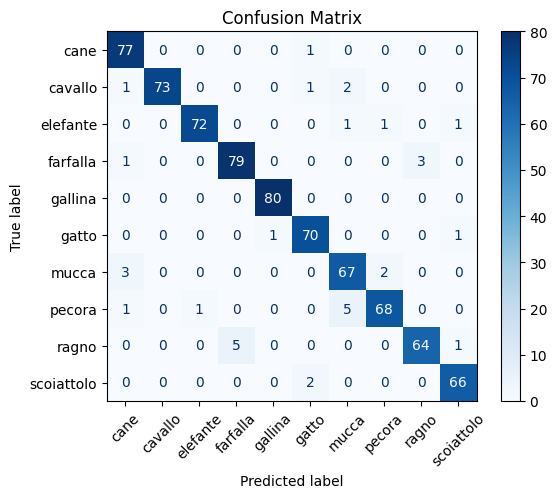


Test Set Metrics for the Best MobileNetV2 Model:
Accuracy: 0.9547
Precision: 0.9554
Recall: 0.9547
F1_score: 0.9547


In [212]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

# Assuming you have trained models: mobilenet_v2, mobilenet_v2_model2
# and history: history[0], history[1]

# Find the best model based on validation accuracy
best_model_index = history.index(max(history, key=lambda x: max(x['val_acc'])))  # Returns 0 or 1
best_mobilenet_model = models[best_model_index]

torch.save(best_model, "best_model_for_third.pth")

# Evaluate the best MobileNetV2 model
mobilenet_results = evaluate_model(best_mobilenet_model, test_loader, full_dataset)

# Print the results
print("\nTest Set Metrics for the Best MobileNetV2 Model:")
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"{metric.capitalize()}: {mobilenet_results[metric]:.4f}")

In [213]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch
# Assuming you have results stored in these variables:
# mobilenet_results (from previous evaluation)
# cnn_results (from section 1.6)
# resnet18_results (from a previous evaluation of the best ResNet18 model)

print("\nComparison of Model Performance:")

# Compare with CNN from scratch
print("\nMobileNetV2 vs. CNN from Scratch:")
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"{metric.capitalize()}: MobileNetV2 = {mobilenet_results[metric]:.4f}, CNN = {results[metric]:.4f}")

# Compare with ResNet18
print("\nMobileNetV2 vs. ResNet18:")
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    print(f"{metric.capitalize()}: MobileNetV2 = {mobilenet_results[metric]:.4f}, ResNet18 = {resnet18_results[metric]:.4f}")


Comparison of Model Performance:

MobileNetV2 vs. CNN from Scratch:
Accuracy: MobileNetV2 = 0.9547, CNN = 0.4747
Precision: MobileNetV2 = 0.9554, CNN = 0.4771
Recall: MobileNetV2 = 0.9547, CNN = 0.4747
F1_score: MobileNetV2 = 0.9547, CNN = 0.4733

MobileNetV2 vs. ResNet18:
Accuracy: MobileNetV2 = 0.9547, ResNet18 = 0.9587
Precision: MobileNetV2 = 0.9554, ResNet18 = 0.9598
Recall: MobileNetV2 = 0.9547, ResNet18 = 0.9587
F1_score: MobileNetV2 = 0.9547, ResNet18 = 0.9589


In [39]:

# Güvenli sınıf listesine ekleyin
torch.serialization.add_safe_globals([CustomCNN])

# Ağırlıkları yükleyin
model = torch.load("best_model_for_first.pth", weights_only=False)


import csv

print(len(test_dataset))

import os
from PIL import Image
import torch
from torchvision import transforms
import pandas as pd

# Step 1: Define the transformation that was used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Resize images to 256x256
    transforms.RandomHorizontalFlip(),          # Random horizontal flip for augmentation
    transforms.ToTensor(),                      # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

# Step 2: Load the paths of test set images
test_dir = 'test-images2'  # Adjust the path to your test images directory
test_image_paths = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]

# Sort the filenames numerically, if needed
sorted_files = sorted(test_image_paths, key=lambda x: int(''.join(filter(str.isdigit, x))))

# Step 3: Preprocess the test set images using the same transformations
test_images = []
for img_path in sorted_files:
    img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
    img = transform(img)  # Apply the same transformation as during training
    test_images.append(img)

# Convert the list of images to a single tensor
test_images = torch.stack(test_images)

# Step 4: Load the best performing model (ensure model is in evaluation mode)
model = torch.load('best_model_for_third.pth', weights_only=False)
model.eval()

# Step 5: Predict class labels for test set images
predictions = []
for image in test_images:
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image)
    predicted_class = output.argmax(dim=1).item()  # Find the index with maximum score
    predictions.append(predicted_class)

# Step 6: Map predicted class labels to corresponding class names
class_labels = {
    0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 
    4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 
    8: 'ragno', 9: 'scoiattolo'
}

# Step 7: Save predictions to CSV file
df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'Label': [class_labels[p] for p in predictions]})
df.to_csv('predictions.csv', index=False)



750


'### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

--------0.96--------- (Rtn_Adn)




## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)
* Discuss practical considerations when choosing between these approaches and models.

Transfer Learning provides faster training and better performance on small datasets by leveraging pretrained models, though it may require fine-tuning and is dependent on the source dataset.

Training from Scratch provides full control over the architecture and is suitable for large datasets but requires more time, data, and computational resources.

Transfer Learning is best for limited data and faster results, leveraging pre-trained models like ResNet18 or MobileNet.

Training from Scratch is ideal for large, task-specific datasets but comes with higher training time and computational cost.